In [2]:
import pandas as pd 

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import gc

In [6]:
df = pd.read_csv(
    'Dataset.csv',
    header = 0, 
    names= ['ts', 'src', 'dst', 'port', 'bytes']
)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924924 entries, 0 to 924923
Data columns (total 5 columns):
ts       924924 non-null float64
src      924924 non-null object
dst      924924 non-null object
port     924924 non-null int64
bytes    924924 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 35.3+ MB


In [8]:
def is_internal(s):
    return s.str.startswith(('12.', '13.', '14.'))

In [9]:
df['src_int'] = is_internal(df['src'])

In [10]:
df['dst_int'] = is_internal(df['dst'])

In [11]:
df['ts']      = pd.to_datetime(df.ts, unit='ms')

In [12]:
df['hour']    = df.ts.dt.hour.astype('uint8')

In [13]:
df['minute']  = df.ts.dt.minute.astype('uint8')

In [14]:
df['port']    = df['port'].astype('uint8')

In [15]:
df.head()

,ts,src,dst,port,bytes,src_int,dst_int,hour,minute
0,2020-01-06 17:00:00,16.79.101.100,12.48.65.39,92,11895,False,True,17,0
1,2020-01-06 17:00:00,18.80.91.46,14.30.29.98,114,42801,False,True,17,0
2,2020-01-06 17:00:00,12.56.32.72,19.96.123.77,27,1169,True,False,17,0
3,2020-01-06 17:00:00,13.32.102.63,14.39.124.47,105,19866,True,True,17,0
4,2020-01-06 17:00:00,12.37.36.110,17.41.50.32,82,1068,True,False,17,0


In [16]:
all_ips = set(df['src'].unique()) | set(df['dst'].unique())

In [ ]:
print('Unique src:', df['src'].nunique())

In [ ]:
print('Unique dst:', df['dst'].nunique())

In [ ]:
print('Total Unique IPs:', len(all_ips))

In [ ]:
ip_type = pd.CategoricalDtype(categories=all_ips)

In [ ]:
df['src'] = df['src'].astype(ip_type)

In [ ]:
df['dst'] = df['dst'].astype(ip_type)

In [5]:
gc.collect()
df.info()

Unique src: 5970
Unique dst: 5999
Total Unique IPs: 5999
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924924 entries, 0 to 924923
Data columns (total 9 columns):
ts         924924 non-null datetime64[ns]
src        924924 non-null category
dst        924924 non-null category
port       924924 non-null uint8
bytes      924924 non-null int64
src_int    924924 non-null bool
dst_int    924924 non-null bool
hour       924924 non-null uint8
minute     924924 non-null uint8
dtypes: bool(2), category(2), datetime64[ns](1), int64(1), uint8(3)
memory usage: 22.5 MB


In [6]:
blacklist_ips = []
answers = []

In [7]:
src_bytes_out = df[df['src_int'] & ~df['dst_int']]\
  .groupby('src')\
  .bytes.sum()\
  .pipe(lambda x: x[x > 0])\
  .sort_values(ascending=False)

src_bytes_out.to_frame().head()

,bytes
src,
13.37.84.125,82957874
12.56.32.111,15253386
14.51.75.107,15217469
14.51.30.86,14713441
13.48.72.30,14574384


In [1]:
df.head()

NameError: name 'df' is not defined

Text(0.5, 0, 'total outbound bytes')

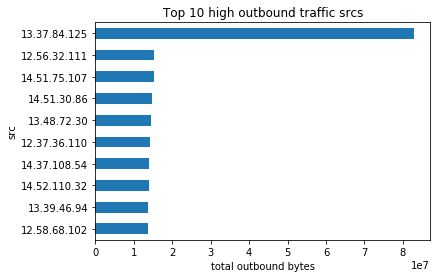

In [8]:
src_bytes_out.head(10)\
    .sort_values()\
    .plot.barh(title='Top 10 high outbound traffic srcs')\
    .set_xlabel('total outbound bytes')

Text(82957874, 100, '13.37.84.125')

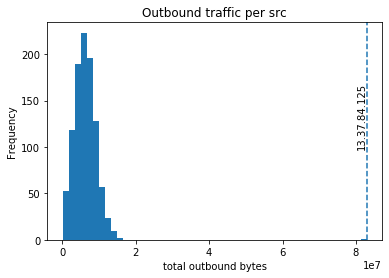

In [9]:
ax = src_bytes_out\
  .plot.hist(bins=50, title='Outbound traffic per src')

ax.set_xlabel('total outbound bytes')
_ = ax.axvline(src_bytes_out.iloc[0], linestyle='--')
plt.text(src_bytes_out.iloc[0], 100, '13.37.84.125', rotation=90, horizontalalignment='right')

In [10]:
blacklist_ips.append('13.37.84.125')
answers.append('13.37.84.125')

Text(0, 0.5, 'Connection counts')

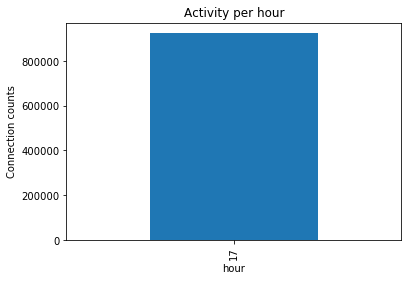

In [11]:
df.groupby('hour').size()\
  .plot.bar(title='Activity per hour')\
  .set_ylabel('Connection counts')

In [12]:
off_hours_activity = df[
    ~df['src'].isin(blacklist_ips)          # Not including previous answers
    & df['src_int'] & ~df['dst_int']        # Outbound
    & (df['hour'] >= 0) & (df['hour'] < 16) # Off hours
].groupby('src')\
  .bytes.sum()\
  .sort_values(ascending=False)\
  .where(lambda x: x > 0)

off_hours_activity.head()

src
16.57.120.106   NaN
15.24.117.48    NaN
15.94.59.123    NaN
19.68.56.123    NaN
19.44.59.45     NaN
Name: bytes, dtype: float64

Text(7443482, 100, '12.55.77.96')

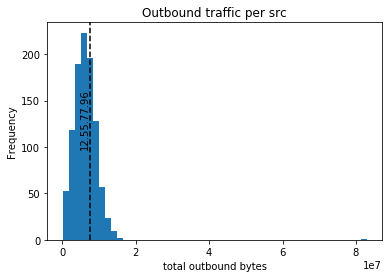

In [15]:
ax = src_bytes_out\
  .plot.hist(bins=50, title='Outbound traffic per src')

ax.set_xlabel('total outbound bytes')
_ = ax.axvline(src_bytes_out.loc['12.55.77.96'], color='k', linestyle='--')
plt.text(src_bytes_out.loc['12.55.77.96'], 100, '12.55.77.96', rotation=90, horizontalalignment='right')

In [16]:
blacklist_ips.append('12.55.77.96')
answers.append('12.55.77.96')

In [17]:
src_port_bytes_df = df[
        ~df['src'].isin(blacklist_ips)     # Not including previous answers
        & df['src_int'] & ~df['dst_int']   # Outbound
    ].groupby(['src', 'port'])\
        .bytes.sum()\
        .reset_index()

ports = src_port_bytes_df['port'].unique()
print('Number of unique ports:', len(ports))

Number of unique ports: 45


In [18]:
src_port_bytes_df[src_port_bytes_df.port == 113]

,src,port,bytes


Text(0, 0.5, 'Total outbound bytes')

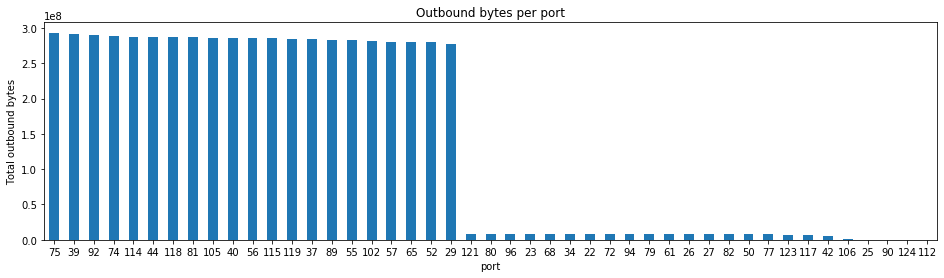

In [19]:
src_port_bytes_df.groupby('port')\
    .bytes.sum()\
    .sort_values(ascending=False)\
    .plot.bar(figsize=(16,4), rot=0, title="Outbound bytes per port")\
    .set_ylabel('Total outbound bytes')

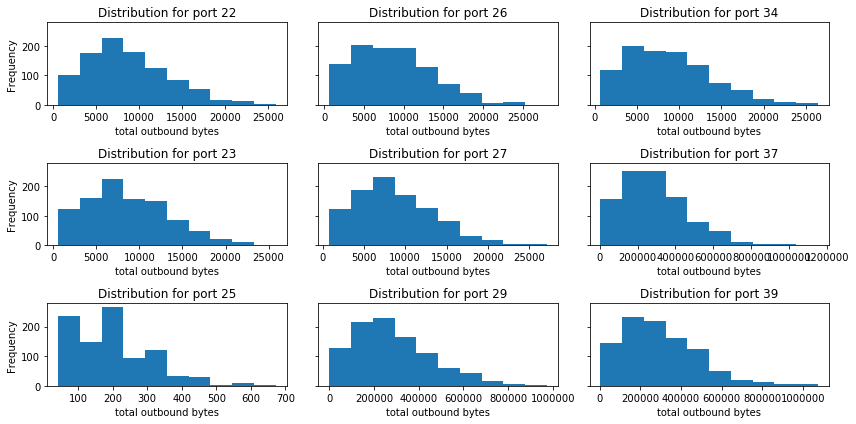

In [20]:
fig, axs = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(12,6))

for idx, p in enumerate(src_port_bytes_df.port.head(9)):
    src_port_bytes_df[src_port_bytes_df.port == p]\
        .bytes.plot.hist(title='Distribution for port {}'.format(p), ax = axs[idx % 3][idx // 3])\
        .set_xlabel('total outbound bytes')

    plt.tight_layout()

Text(0.5, 0, 'Max z-score')

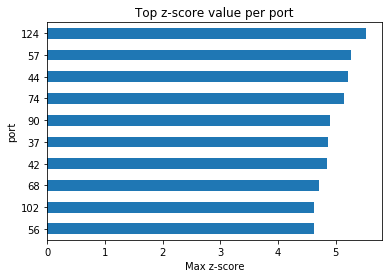

In [21]:
src_port_bytes_df\
  .groupby('port')\
  .apply(lambda x: np.max((x.bytes - x.bytes.mean()) / x.bytes.std()))\
  .sort_values(ascending=True)\
  .tail(10)\
  .plot.barh(title='Top z-score value per port')\
  .set_xlabel('Max z-score')

In [22]:
src_124 = src_port_bytes_df\
  .pipe(lambda x: x[x['port'] == 124])\
  .sort_values('bytes', ascending=False).head(1)

src_124

,src,port,bytes
266759,12.30.96.87,124,829.0


Text(829.0, 100, '12.30.96.87')

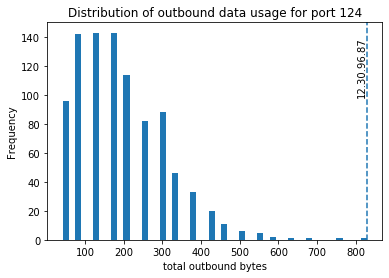

In [23]:
ax = src_port_bytes_df[src_port_bytes_df.port == 124]\
    .bytes.plot.hist(bins=50, title='Distribution of outbound data usage for port 124')

ax.set_xlabel('total outbound bytes')
_ = ax.axvline(src_124.iloc[0, 2], linestyle='--')
plt.text(src_124.iloc[0, 2], 100, '12.30.96.87', rotation=90, horizontalalignment='right')

In [24]:
blacklist_ips.append('12.30.96.87')
answers.append('124')

In [25]:
df[~df['src_int']]\
  .drop_duplicates(('src', 'port'))\
  .groupby('port').size()\
  .sort_values()\
  .head()

port
113      1
106    885
123    899
124    910
112    918
dtype: int64

In [26]:
df[~df['src_int'] & (df['port'] == 113)][['src', 'dst', 'port']]

,src,dst,port
397451,15.104.76.58,12.45.104.32,113


In [61]:
df[(df['src'] == '15.104.76.58') & (df['dst'] == '12.45.104.32')]\
    [['src', 'dst', 'port']]

,src,dst,port
397451,15.104.76.58,12.45.104.32,113


In [28]:
answers.append('113')

In [29]:
import networkx
from networkx.algorithms.approximation.clique import large_clique_size 
from collections import Counter

In [30]:
internal_edges_all = df[
  df['src_int'] & df['dst_int']
].drop_duplicates(['src', 'dst', 'port'])
internal_ports = internal_edges_all.port.unique()

In [31]:
port_upper_bounds = []
for p in internal_ports:
    internal_edges = internal_edges_all\
        .pipe(lambda x: x[x['port'] == p])\
        .drop_duplicates(['src', 'dst'])

    edges = set()
    for l, r in zip(internal_edges.src, internal_edges.dst):
        k = min((l, r), (r, l))
        edges.add(k)
    
    degrees = Counter()
    for (l, r) in edges:
        degrees[l] += 1
        degrees[r] += 1
    
    max_clique_size = 0
    min_degrees = len(degrees)
    for idx, (node, degree) in enumerate(degrees.most_common()):
        min_degrees = min(min_degrees, degree)
        if min_degrees >= idx:
            max_clique_size = max(max_clique_size, idx+1)
        if min_degrees < max_clique_size:
            break
            
    port_upper_bounds.append((p, max_clique_size + 1))

In [32]:
port_upper_bounds.sort(key = lambda x: -x[-1])
port_upper_bounds[:5]

[(40, 36), (105, 35), (44, 35), (56, 35), (55, 35)]

In [33]:
max_port = 0
curr_max_clique = 0
for p, max_clique_upper_bound in port_upper_bounds:
    if curr_max_clique > max_clique_upper_bound: break
    
    internal_edges = internal_edges_all\
        .pipe(lambda x: x[x['port'] == p])\
        .drop_duplicates(['src', 'dst'])
  
    internal_nodes = set(internal_edges.src) | set(internal_edges.dst)
    G = networkx.Graph()
    G.add_nodes_from(internal_nodes)
    for l, r in zip(internal_edges.src, internal_edges.dst):
        G.add_edge(l, r)        
        
    _size = large_clique_size(G) 
    if curr_max_clique < _size:
        curr_max_clique = _size
        max_port = p

In [34]:
print('Port {} has approx. max clique size {}'.format(max_port, curr_max_clique))
answers.append(str(max_port))

Port 40 has approx. max clique size 4


In [35]:
single_dst = df[~df['src_int'] & df['dst_int']]\
    .drop_duplicates(['src', 'dst'])\
    .src.value_counts()\
    .pipe(lambda x: x[x == 1])\
    .index

print('Count of "little reason" src:', len(single_dst))

Count of "little reason" src: 19


In [36]:
df[~df['src_int'] & df['dst_int']]\
    .pipe(lambda x: x[x.src.isin(single_dst)])\
    .drop_duplicates(['src', 'dst'])\
    .groupby('dst').size()\
    .where(lambda x: x > 0).dropna()

dst
13.56.39.74      1.0
12.48.42.74      1.0
12.43.57.22      1.0
14.31.119.101    1.0
12.45.30.70      1.0
13.57.99.96      1.0
13.55.75.103     1.0
14.57.40.79      1.0
12.45.25.43      1.0
13.46.35.35      1.0
13.38.107.31     1.0
12.56.80.111     1.0
12.38.44.45      1.0
13.35.40.50      1.0
13.34.88.95      1.0
14.47.111.24     1.0
14.52.45.116     1.0
13.59.64.32      1.0
14.33.32.62      1.0
dtype: float64

In [37]:
df[~df['src_int'] & df['dst_int']]\
  .pipe(lambda x: x[x.src.isin(single_dst)])\
  .drop_duplicates(['src', 'dst'])\
  .head()

,ts,src,dst,port,bytes,src_int,dst_int,hour,minute
18659,2020-01-06 17:00:00,19.90.46.28,14.31.119.101,55,30001,False,True,17,0
23763,2020-01-06 17:00:00,15.45.106.36,14.47.111.24,75,5087,False,True,17,0
112123,2020-01-06 17:00:00,15.47.120.66,13.59.64.32,114,5823,False,True,17,0
126977,2020-01-06 17:00:00,17.26.123.90,12.38.44.45,39,17120,False,True,17,0
164487,2020-01-06 17:00:00,15.121.121.121,13.38.107.31,115,7987,False,True,17,0


In [38]:
blacklist_ips.append('14.45.67.46')
answers.append('14.45.67.46')

In [39]:
df[
    df['src_int'] & df['dst_int']
    & (df['dst'] == '14.45.67.46')
    & (df['port'] == 27)
].drop_duplicates('src')

,ts,src,dst,port,bytes,src_int,dst_int,hour,minute


In [40]:
blacklist_ips.append('14.51.84.50')
answers.append('14.51.84.50')

In [41]:
periodic_callbacks = df[df['src_int'] & ~df['dst_int']]\
  .drop_duplicates(['dst', 'minute'])\
  .groupby('dst').size()\
  .pipe(lambda x: x[(x > 0) & (x <= 4)])\
  .sort_values()

periodic_callbacks

dst
17.26.69.65      1
15.101.96.41     1
17.33.122.88     1
17.114.46.103    1
19.25.109.51     1
                ..
17.29.29.61      1
17.58.92.120     1
18.15.87.81      1
19.118.34.87     1
16.57.120.106    1
Length: 4999, dtype: int64

In [45]:
answers.append('51')

In [46]:
df[~df['dst_int']]\
    .groupby('dst')\
    .bytes.std()\
    .sort_values()\
    .head(10)

dst
19.118.96.47      14348.668258
18.120.93.68      14623.899706
19.125.107.101    14826.902474
16.92.46.73       14972.621838
18.91.22.81       15287.965274
16.63.30.54       15414.481321
19.123.65.83      16259.844999
15.91.91.116      16307.281133
19.95.75.61       16350.752653
19.76.25.105      16379.555571
Name: bytes, dtype: float64

In [47]:
df[~df['dst_int']]\
    .groupby('port').size()\
    .sort_values()\
    .head(10)

port
36       35
32       39
95       44
21       52
78       52
117    4191
106    4196
42     4207
112    4211
123    4243
dtype: int64

In [48]:
df.loc[
    df.dst.isin(periodic_callbacks.index),
    ['src', 'dst', 'bytes']
].head()

,src,dst,bytes
2,12.56.32.72,19.96.123.77,1169
4,12.37.36.110,17.41.50.32,1068
5,12.49.35.70,19.87.55.92,82927
7,14.49.37.85,15.95.99.95,42
8,12.53.30.67,19.90.85.43,35667


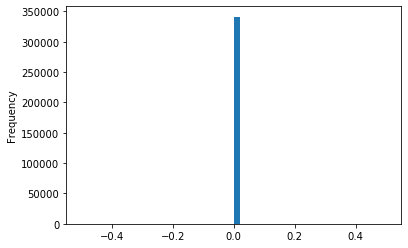

In [49]:
df[df.dst.isin(periodic_callbacks.index)]\
    .ts.diff()\
    .dt.total_seconds()\
    .plot.hist(bins=50)

In [50]:
dst_counts = df[df['src_int'] & df['dst_int']]\
    .drop_duplicates(['src', 'dst'])\
    .groupby('src').size()\
    .sort_values(ascending=False)
dst_counts.head()

src
14.51.62.54     169
12.49.68.75     164
14.41.99.120    163
12.58.122.56    162
12.58.54.120    160
dtype: int64

In [49]:
blacklist_ips.append('13.42.70.40')
answers.append('13.42.70.40')

In [52]:
# Getting internal only connections
int_df = df[df['src_int'] & df['dst_int']]\
    .pipe(lambda x: x[~x.src.isin(blacklist_ips)])\
    .drop_duplicates(('src', 'dst', 'port'))

In [53]:
print('Unique dsts')
int_df\
  .drop_duplicates(['src', 'dst'])\
  .groupby('src').size()\
  .sort_values(ascending=False).head()

Unique dsts


src
14.51.62.54     169
12.49.68.75     164
14.41.99.120    163
12.58.122.56    162
12.58.54.120    160
dtype: int64

In [60]:
print('Predicted IP & Ports')
int_df\
  .drop_duplicates(['src', 'port'])\
  .groupby('src').size()\
  .sort_values(ascending=False).head()

Predicted IP & Ports


src
13.45.121.86     45
13.43.22.89      45
13.52.123.119    45
14.39.53.59      45
14.46.111.115    45
dtype: int64